In [1]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

In [2]:
# set random seed
random.seed(42)

In [3]:
def prob(x, bin_size=20):
    """
    Calculate the probability that there is at least the bid quantity on the table.
    Args:
    x (list): List of values [total dice number, player dice number, claim quantity, player has].
    bin_size (int): Size of the probability bucket (default is 20).
    
    Returns:
    int: Calculated probability.
    """
    if x[2] <= x[3]:
        return 1 * bin_size
    else:
        n = x[0] - x[1]   
        prob = 0
        for k in range(min(x[2] - x[3], n), n + 1):
            prob += math.comb(n, k) * (1/6)**k * (5/6)**(n-k)
        return int(np.floor(prob*bin_size))

# Useful Functions

In [4]:
def roll_table(rolls, Deep=False):
    """
    Generate a table of rolled dice values.
    Args: rolls (list): List of rolled dice values.
    Returns: list, Table of rolled dice values.
    """
    if Deep == False:
        rt = np.bincount(rolls, minlength=7)[1:]
        return rt.tolist()
    else:
        m = len(rolls)
        rt = 0
        for i in range(m):
            rt += np.bincount(rolls[i], minlength=7)[1:]
        return rt.tolist()

In [5]:
def playerClaim(dice_truth, total, last_claim=None):
    '''
    dice_truth: List, the numbers the player has
    total: total number of dices on the table
    last_claim: [amount, number]
    '''
    s = random.randint(1,3)
    t = random.randint(1,3)
    rt = roll_table(dice_truth)
    
    if last_claim == None:
        if s==1:  # bluffing
            number = random.randint(1,6)
            size = rt[number-1] + 1
        elif s==2:   # honest
            number = np.max(dice_truth)  # index
            size = rt[number-1]
        else:   # random
            number = random.randint(1,6)
            size = random.randint(1,total)
            
    else:
        A, B = last_claim
        if s==1:  # bluffing
            if B == 6:
                number = B
                size = A+1
            elif t == 1:
                number = B
                size = rt[number-1] + 1
            elif t == 2:
                number = B + 1 
                size = A
            else:
                number = B + 1 
                size = A + 1
        elif s==2:   # honest
            own_most = np.argmax(dice_truth)  # index
            number = own_most+1
            size = A + 1
        else:   # random
            if B == 6:
                number = B
                size = random.randint(A+1,total)
            elif t==1:
                number = random.randint(B+1,6)
                size = random.randint(A,total)
            elif t==2:
                number = random.randint(B,6)
                size = random.randint(A+1,total)
            else:
                number = random.randint(B+1,6)
                size = random.randint(A+1,total)
            
    return [size,number]

In [6]:
# def decide(rolls, claim, total):
#     '''
#     ft: numbers the player has
#     player dice number, claim quantity, player has].
#     '''
#     ft = roll_table(rolls)
#     A, B = claim
#     doubt = False
#     probability = prob([total,sum(ft), A, ft[B-1]], bin_size=20)
   
#     if probability <= 5:
#         doubt = True
#     if claim[0] >= total:
#         doubt = True
        
#     return doubt

In [7]:
def decide(rolls, claim, total):
    '''
    ft: numbers the player has
    '''
    ft = roll_table(rolls)
    startegy = random.randint(1,2)
    A, B = claim
    doubt = False
    probability = prob([total,sum(ft), A, ft[B-1]], bin_size=1)
   
    if startegy == 1:
        doubt = random.sample([True, False],1)
    else:
        doubt = np.random.choice([True, False], p=[1-probability,probability])
        
    return doubt

In [8]:
def Judge(Roll, claim):
    '''
    Roll: all the rolled numbers on the table
    claim: the claim doubted
    '''
    A, N = claim
    ft = roll_table(Roll, Deep=True)
    if A <= ft[N-1]:
        return False
    else: 
        return True

In [9]:
def Combinations(ndice, length = 6):
    """
    Generate all combinations of values in a sequence of length n_values
    where the sum of each combination is number of dices.
    return list of tuples
    """
    final = []
    for n in range(1,ndice+1):
        all_combinations = list(product(range(n + 1), repeat=length))
        result = [combo for combo in all_combinations if sum(combo) == n]
        final = final + result
        
    return final

In [66]:
def Q_initialise(ndice, nplayer):
    '''
    simple Q table
    ndice: number of dice
    nplayer: number of players
    column: last_claim
    '''
    total_claim_number = ndice * nplayer
    row_label = Combinations(ndice)
    state_number = len(row_label)
    column_label = [f"{i}.{j}" for i in range(1, total_claim_number+1) for j in range(1, 7)]

    Q = np.zeros((state_number, total_claim_number*6)) + 0.5
    Q_df = pd.DataFrame(data=Q, index=row_label, columns=column_label)

    Q_df.index = pd.Index([''.join(map(str, x)) for x in row_label], dtype='object')

    return Q_df

In [11]:
# def update(play_memory, Q_matrix, reward, alpha=0.05):
#     '''
#     play: "State", "Last claim", "Reward"
#     Q_matrix
#     reward: 
#     '''
#     Qcopy = Q_matrix.copy()
#     for index, row in play_memory.iterrows():
#         s = row['State']
#         last_c = row['Last claim']
#         l_c = last_c[0] + 0.1 * last_c[1]
#         sft = roll_table(s, Deep=False)
#         new_prob = Q_matrix.loc[tuple(sft), "{}".format(l_c)] + alpha * reward * (1 - Q_matrix.loc[tuple(sft), "{}".format(l_c)])
#         # print('reward',reward)
#         # print('new_prob',new_prob)
#         new_prob = new_prob.clip(0, 1)
#         # print('new_prob after clip',new_prob)
#         Q_matrix.loc[tuple(sft), "{}".format(l_c)] = new_prob

#     if any(Qcopy != Q_matrix):
#         print('updated')
#     return Q_matrix

In [12]:
# def update(play_memory, Q_matrix, reward, alpha=0.1):
#     '''
#     play: "State", "Last claim", "Reward"
#     Q_matrix
#     reward: 
#     '''
#     Qcopy = Q_matrix.copy()
#     # pd.options.mode.chained_assignment = None
#     for index, row in play_memory.iterrows():
#         s = row['State']
#         last_c = row['Last claim']
#         l_c = last_c[0] + 0.1 * last_c[1]
#         sft = roll_table(s)
#         val = Qcopy.loc[tuple(sft), "{}".format(l_c)]
#         new_prob = val + alpha * reward * (1 - val)
#         # print(Qcopy.loc[tuple(sft), "{}".format(l_c)])
#         # print('reward',reward)
#         # print('new_prob',new_prob)
#         new_prob = new_prob.clip(0, 1)
#         # print('new_prob after clip',new_prob)
#         # print('First time', Qcopy.loc[tuple(sft), "{}".format(l_c)])
#         Qcopy.sort_index(inplace=True)
#         Qcopy.loc[tuple(sft), "{}".format(l_c)] = new_prob
#         # print('Second time',Qcopy.loc[tuple(sft), "{}".format(l_c)])
    
#     if Qcopy.equals(Q_matrix):
#         print('Not updated')
# #     else:
# #         print('-----')
#     return Qcopy

In [107]:
def update(play_memory, Q_matrix, reward, alpha=0.1):
    '''
    play_memory: "State", "Last claim"
    Q_matrix
    reward: 
    '''
    Qcopy = Q_matrix.copy()
    length = len(play_memory)
    for i in range(length):
        s = play_memory[i][0]
        last_c = play_memory[i][1]
        l_c = last_c[0] + 0.1 * last_c[1]     # last claim
        sft = roll_table(s)         # state frequency table
        index = ''.join(map(str, sft))
        val = Qcopy.loc[index, "{}".format(l_c)]
        # new_prob = val + alpha * reward * (1 - val)
        new_prob = val + alpha * reward * (1 - val)
        
        # print(Qcopy.loc[tuple(sft), "{}".format(l_c)])
        # print('reward',reward)
        # print('new_prob',new_prob)
        new_prob = new_prob.clip(0, 1)
        # print('new_prob after clip',new_prob)
        # print('First time', Qcopy.loc[''.join(map(str, sft)), "{}".format(l_c)])
        # Qcopy.sort_index(inplace=True)
        Qcopy.loc[index, "{}".format(l_c)] = new_prob
        # print('Second time',Qcopy.loc[''.join(map(str, sft)), "{}".format(l_c)])
    
#     if Qcopy.equals(Q_matrix):
#         print('-----------Not updated------------')
    return Qcopy

In [14]:
def AgentClaim(dice_truth, total, last_claim):
    return playerClaim(dice_truth, total, last_claim)

def AgentDecide(Q_mat, state, claim, total):
    '''
    state: list of numbers
    claim: [amount, number]
    '''
    state_ft = roll_table(state)
    claim_label = claim[0] + 0.1 * claim[1]
    Dprob = Q_mat.loc[''.join(map(str, state_ft)), "{}".format(claim_label)]

    decision = np.random.choice([True, False], p=[Dprob, 1-Dprob])
    if claim[0] >= total:
        decision = True
    
    return decision

In [19]:
def Round(nplayer, dice_count, control, a=1):
    '''
    When someone doubts, a new round starts
    control: input the number of initial player
    nplayers: number of players
    dice_counts: list of how many dice each player has
    '''
    # initialisation
    # roll the dice
    Roll = [sorted(random.sample(range(1, 7), dice_count[x])) if dice_count[x] != 0 else [0]*6 for x in range(nplayer)]

    total = sum(dice_count)
    Doubt = False
    ctrl = []
    state = []
    action = []
    claim = None
    
    # no dice no play
    while dice_count[control-1] == 0:
        control = control % nplayer + 1

    # Make a Claim (Initial)
    if control != a:
        claim = playerClaim(Roll[control-1], total, claim)
    else:  # agent play
        claim = AgentClaim(Roll[a-1], total, claim)

    while Doubt == False:
        # no dice no play
        control = control % nplayer + 1
        while dice_count[control-1] == 0:
            control = control % nplayer + 1
            
        # Next player decide
        if control != a:
            Doubt = decide(Roll[control-1], claim, total)
            if Doubt == False:
                claim = playerClaim(Roll[control-1], total, claim)
                control = control % nplayer + 1
        else:  # agent decide
            Doubt = AgentDecide(Q, Roll[a-1], claim, total)
            if Doubt == False:
                claim = AgentClaim(Roll[control-1], total, claim)
                control = control % nplayer + 1
                
    return control, Roll, claim

In [16]:
def Play(nplayer, ndice, Q_mat, control=1, a=1):
    # initiate
    dice_counts = [ndice] * nplayer
    # record for learning
    Agent_lose = 'unknown'
    columns = ["State", "Last claim"]  # Replace with your column names
    plays_record = []
    
    while any(dice_counts) != 0:
        # terminate and remove players
        if dice_counts[0] == 0:
            Agent_lose = True
            break
        
        # each round 
        new_control, Roll_for_judge, claim_for_judge = Round(nplayer, dice_counts, control=control, a=a)
        control = new_control
        challenge = Judge(Roll_for_judge, claim_for_judge)
        if new_control == a:
            # setting reward
            if challenge == True:
                reward = 1
            else:
                reward = -1
            # new_data = pd.DataFrame({"State": [Roll_for_judge[a-1]], "Last claim": [claim_for_judge]})  
            new_data = [[Roll_for_judge[a-1],claim_for_judge]] 
            plays_record += new_data
            # update for once
            Q_mat = update(new_data, Q_mat, reward)
        if challenge == True:
            if dice_counts[new_control-2] != 0: 
                dice_counts[new_control-2] -= 1
        else:
            if dice_counts[new_control-1] != 0: 
                dice_counts[new_control-1] -= 1
    
    # Update Q for whole play
    if Agent_lose == True:
        reward = -10 
        Q_mat = update(plays_record, Q_mat, reward)
    else:
        reward = 10 
        Q_mat = update(plays_record, Q_mat, reward)
        
    if Agent_lose == True:
        return 0, Q_mat
    else:
        return 1, Q_mat

In [17]:
Q = Q_initialise(6,4)
Q

,1.1,1.2,1.3,1.4,1.5,1.6,2.1,2.2,2.3,2.4,...,23.3,23.4,23.5,23.6,24.1,24.2,24.3,24.4,24.5,24.6
000001,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
000010,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
000100,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
001000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
010000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500010,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
500100,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
501000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
510000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [18]:
L = []
M = []
for i in range(1000000):
    a, Q = Play(4,6,Q)
    L.append(a)

In [70]:
Q

,1.1,1.2,1.3,1.4,1.5,1.6,2.1,2.2,2.3,2.4,...,23.3,23.4,23.5,23.6,24.1,24.2,24.3,24.4,24.5,24.6
000001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
000010,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
000100,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
001000,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
010000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500010,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
500100,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
501000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
510000,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


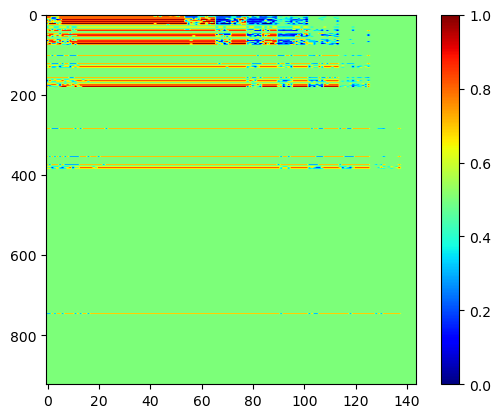

In [102]:
rows, cols = Q.shape
aspect_ratio = cols / rows

plt.imshow(Q, cmap='jet', aspect=aspect_ratio)
# plt.xlabel()
# plt.ylabel()
plt.colorbar()
plt.show()

Text(0.5, 0, 'iterations')

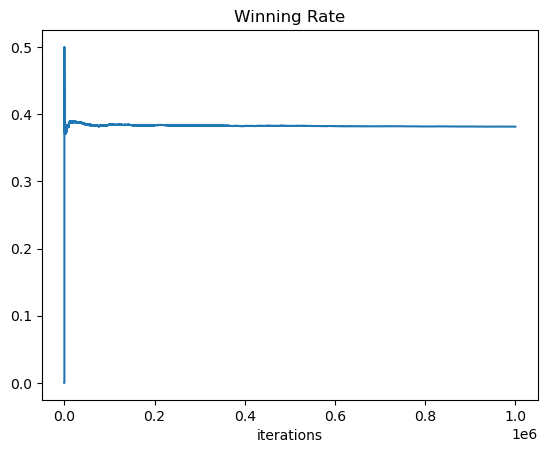

In [37]:
Rate = []
tol = len(L)
for i in range(tol):
    r = sum(L[:i])/(i+1)
    Rate.append(r)
    
plt.plot(Rate)
plt.title('Winning Rate')
plt.xlabel('iterations')

In [24]:
import seaborn as sns

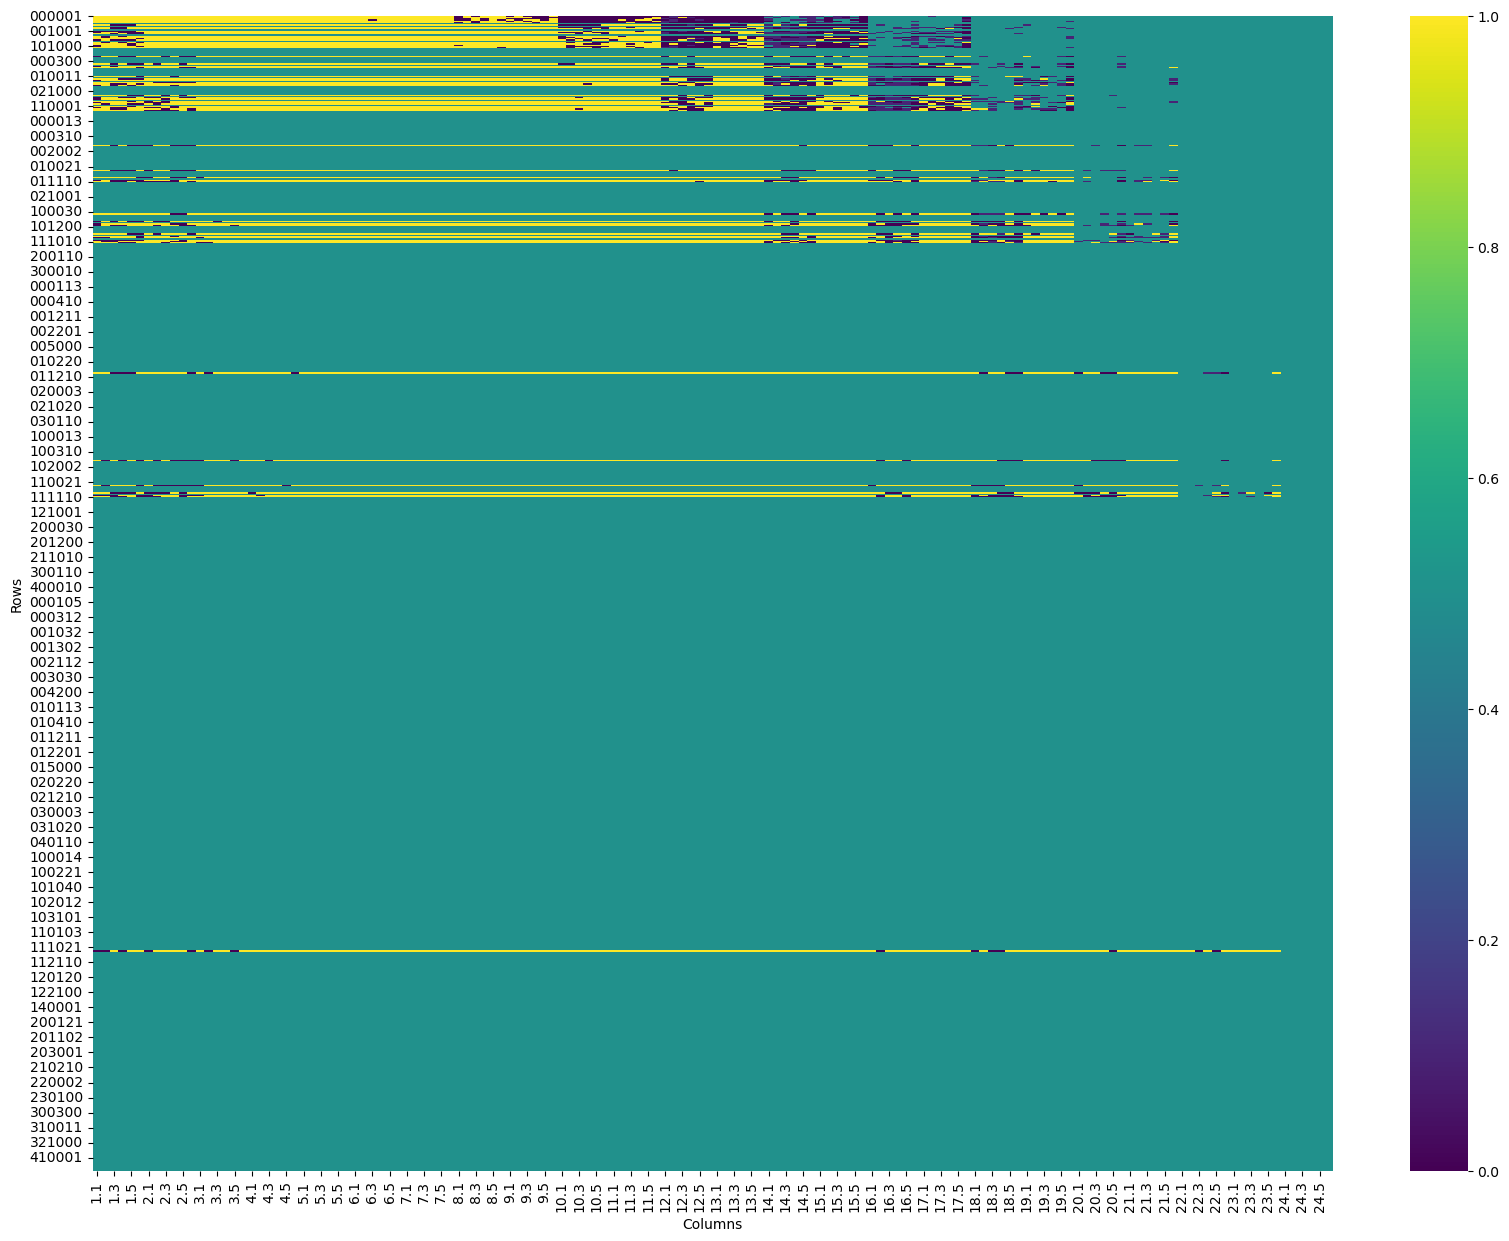

In [36]:
# Create heatmap

# Set axis labels
plt.figure(figsize=(20, 15))
sns.heatmap(Q, annot=False, cmap='viridis', fmt='.1f')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Show the plot
plt.show()

# 3 dice, 4 players

In [104]:
Ma = Q_initialise(3,4)   # ndice, nplayer

In [105]:
L1 = []
for i in range(80000):
    a, Ma = Play(4,3,Ma)    # nplayer, ndice
    L1.append(a)

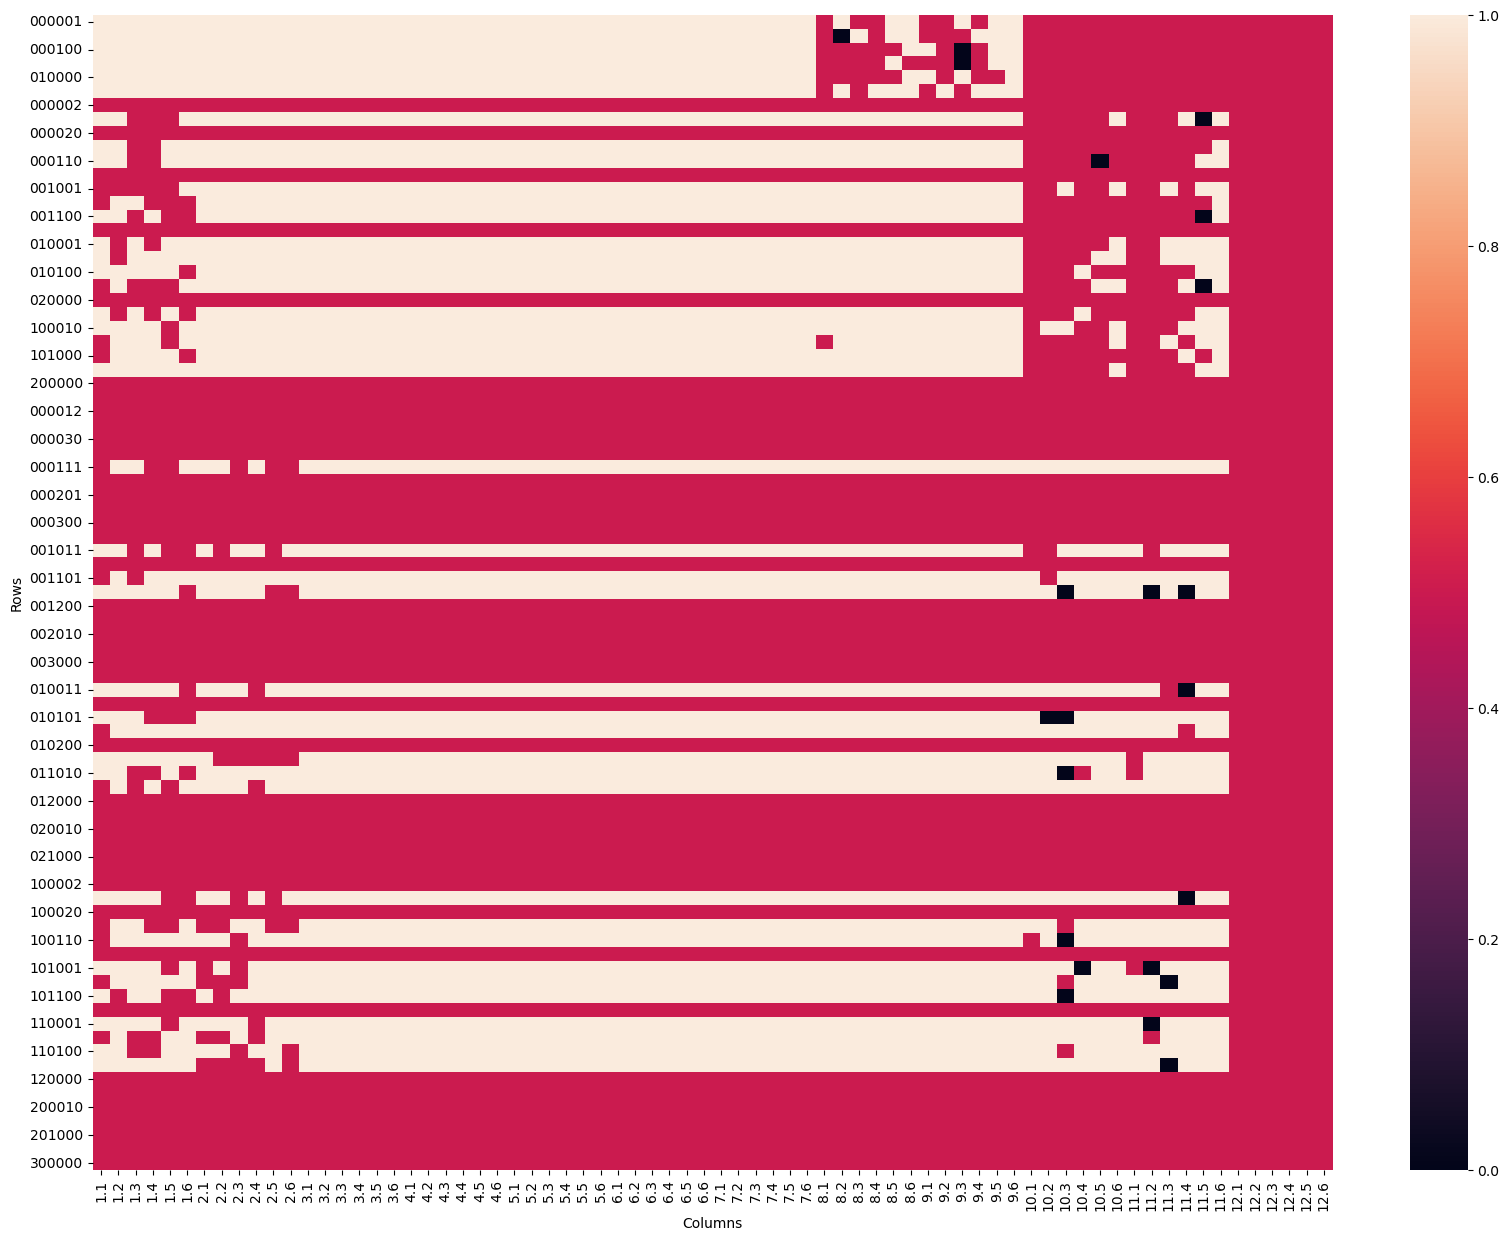

In [106]:
plt.figure(figsize=(20, 15))
sns.heatmap(Ma, annot=False, fmt='.1f')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Show the plot
plt.show()

In [70]:
Rate = []
tol = len(L1)
for i in range(tol):
    r = sum(L1[:i])/(i+1)
    Rate.append(r)

Text(0.5, 0, 'Iterations')

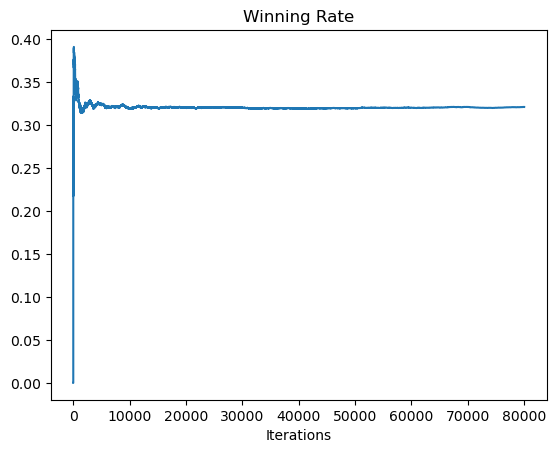

In [71]:
plt.plot(Rate)
plt.title('Winning Rate')
plt.xlabel('Iterations')

# 2 player, 6 dice

In [79]:
Mb = Q_initialise(3,2)   # ndice, nplayer

In [80]:
L2 = []
for i in range(80000):
    b, Mb = Play(2,3,Mb)    # nplayer, ndice
    L2.append(b)

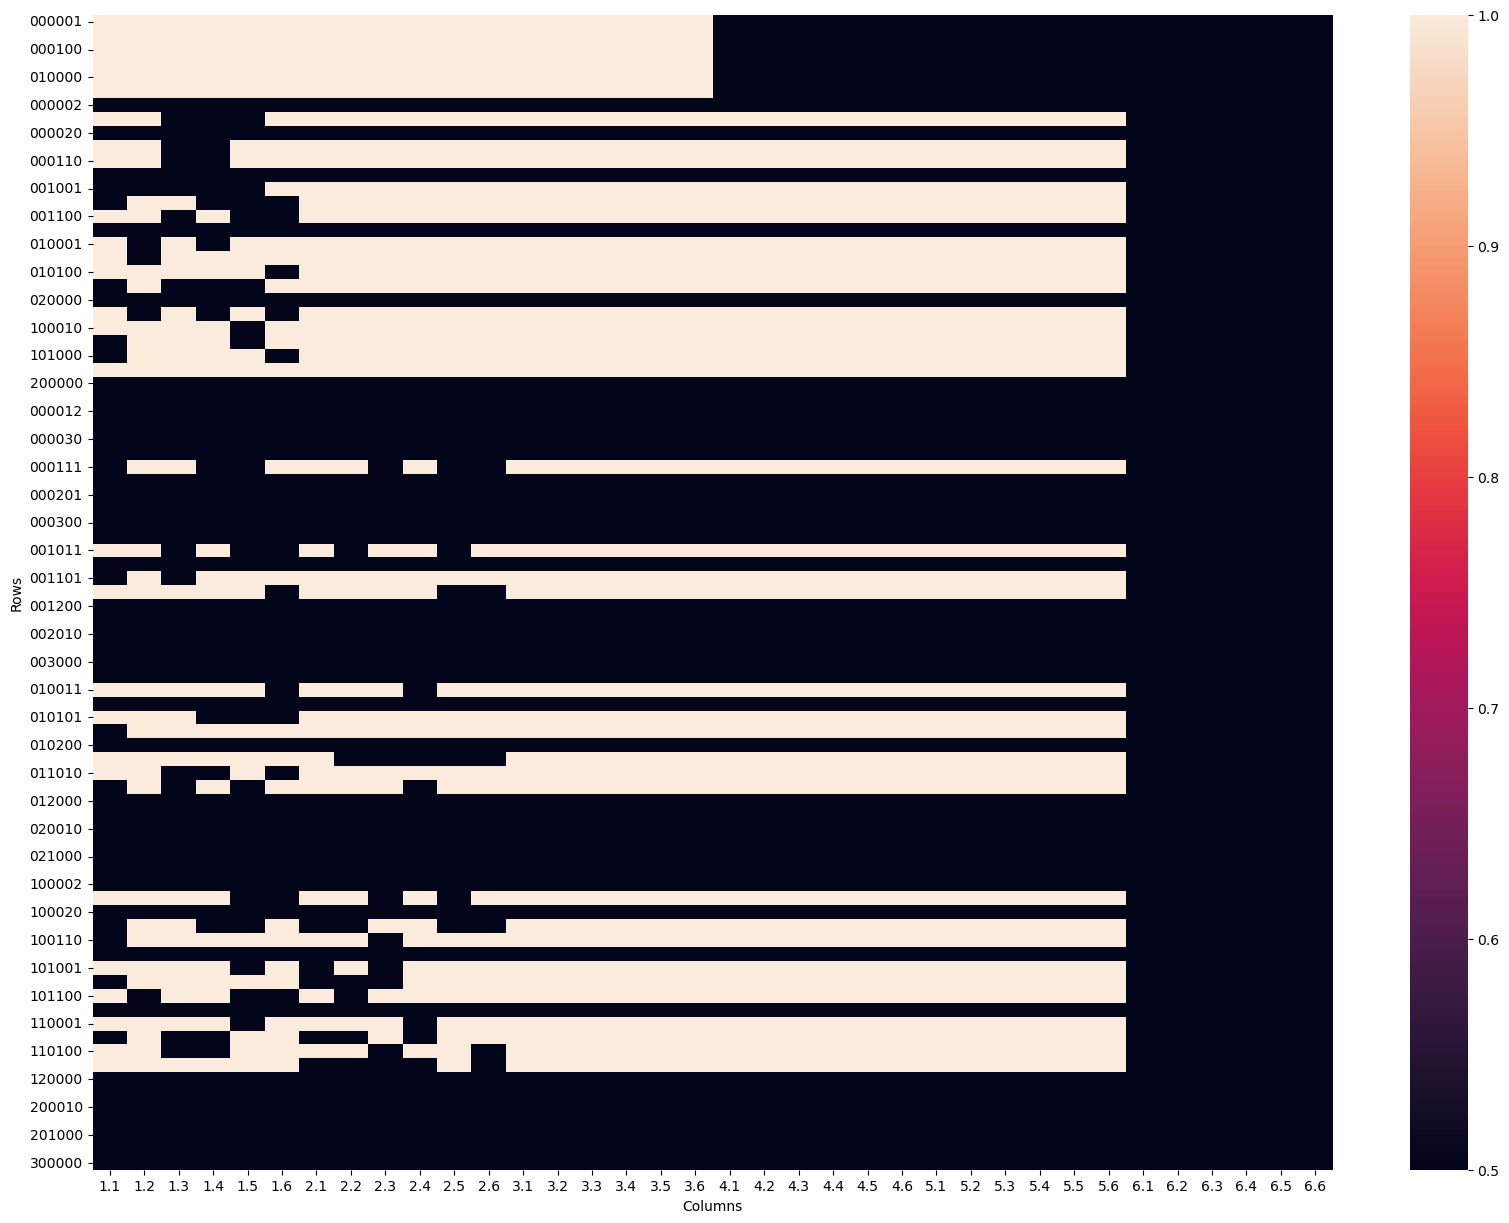

In [81]:
plt.figure(figsize=(20, 15))
sns.heatmap(Mb, annot=False,fmt='.1f')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Show the plot
plt.show()

In [82]:
Rate = []
tol = len(L2)
for i in range(tol):
    r = sum(L2[:i])/(i+1)
    Rate.append(r)

Text(0.5, 0, 'Iterations')

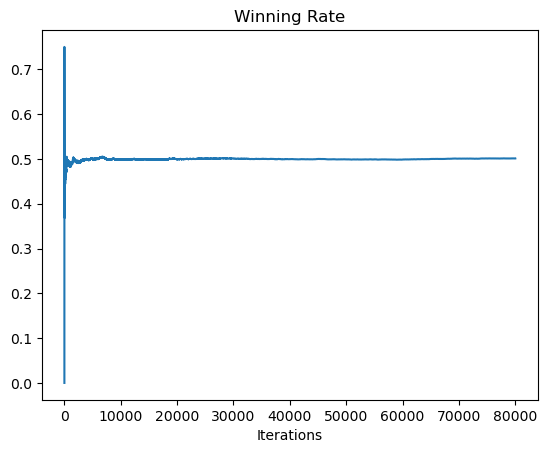

In [95]:
plt.plot(Rate)
# T = np.arange(0,80000,1)
# sh = np.zeros(80000)+0.5
# plt.plot(T, sh, '--',color = 'black')
# plt.xlim(60000, 80000)
plt.title('Winning Rate')
plt.xlabel('Iterations')

In [93]:
Rate[-1]

0.5010625

Text(0.5, 0, 'Iterations')

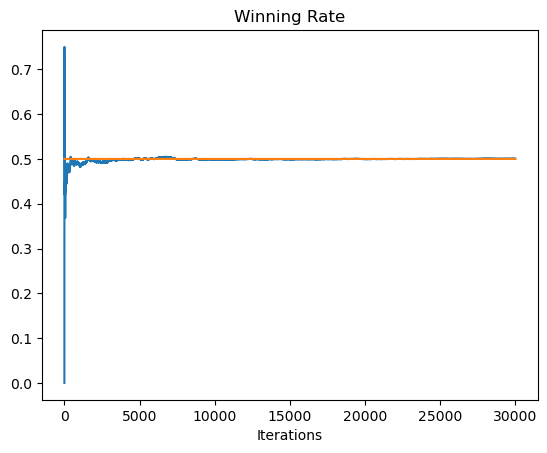

In [88]:
plt.plot(Rate[:30000])
T = np.arange(0,30000,1)
sh = np.zeros(30000)+0.5
plt.plot(T, sh)
plt.title('Winning Rate')
plt.xlabel('Iterations')